In [47]:
# load libs
import numpy as np 
import scipy.io
from scipy.io   import  loadmat
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from scipy.optimize import curve_fit 
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime
from itertools import chain
from scipy.optimize import curve_fit

### ***Functions***

#### ***HR/NR Fit Boundaries***

In [48]:
### Model Estimates...based on nothing soild - subject to change 
c50_b = [0,50] # contrast level that yields 50% of max response
n_b = [0,4] # determin curve arc for fitting 
Rmax_b = [0,1] # max response, post-normalization maxrespone = ~ 1.25 / 1.3
b_b = [0,0.5] # starting value, should be around 0-0.9 ish
boundaries=([c50_b[0],n_b[0],Rmax_b[0],b_b[0]], [c50_b[1],n_b[1],Rmax_b[1],b_b[1]]) # Boundary Params for C50, N, Rmax and B
startingGuess = [40,0.1,1,0] # Initial guess for 2f params

# hyperbolic ratio / naka rushton
def naka_rushton(C, C50, n, Rmax, b):
    """
    This function models neural responses captured by Contrast Response Functions
    C50 (parameter 1) : Contrast level that yields half of max response (contrast %)
    n (parameter 2)   : Determines the curve arc for fitting (small integer)
    Rmax (Parameter 3): Max response elicited (mv)
    b (Parameter 4)   : Starting value (origin)
    """
    return ((Rmax * (( C ** n) / ( C50 ** n + C ** n))) + b)
#############################################################
def NakaRushtonDataFrames(condDataIn, HemiBool,AttnBool,subs):
    NakaDataFrames = []
    FitValues_mat= np.zeros((4,7))

    for SubjInfIn in range(int(len(subs))):
        dataIn = condDataIn[SubjInfIn,:]

        FitValues_mat[:,0] = Subj_Ids[SubjInfIn] # subject identification
        FitValues_mat[:,1] = HarmonicValIn # enter hamronic informaiton
        FitValues_mat[:,2] = AttnBool  #attnTo info 
        FitValues_mat[:,3] =  HemiBool #Hemifield info
        FitValues_mat[:,4] =  np.array(np.arange(0,4,1)) # 0 = c50, 1 = n, 2 = -rmax, 3 = b
        FitValues_mat[:,5] = dataIn[0,:] # pre nk paramters 
        FitValues_mat[:,6] = dataIn[1,:] # post nr parameters

        NakaDataFrames.append(FitValues_mat)

    return NakaDataFrames

In [49]:
# to organizze data for fitting: saturtion index and sorting 
def CombinePrePostResponses(DataIn, Cond2Import, HarmonicIndex):
    """combine data sets in terms of attention and hemifield, sorting ONLY
        returns: [Subject x preopst x sweep] array
    """
    Rows = int(len(DataIn))
    Cols = 2
    Data_PrePost_Mat = np.zeros((Rows,Cols,6)) # numsubs x contrasts            
    for combine in range(len(DataIn)):
        Data_PrePost_Mat[combine,:,:] = DataIn[combine][Cond2Import][HarmonicIndex,:,:]
    return Data_PrePost_Mat

In [50]:
'Obtain Root Mean Square Acoss all harmonics of interest'
def Init_RMS(DataF,Subj,ExptCo,Pick_hSum):
    '''This function obtins the Root Mean Square of a single particpant for a single
    hemifield condition
    INPUT:
    DataF, Subj, ExptCo = DataString[Subj][ExptCo] = [Harmonic x PrePost x Sweep] Array
    Pick_hSum = range to index harmonics to perform RMS 

    RETURNS: 
    A [2x6] array '''
    print(f'Harmonics to selcted for RMS :{Pick_hSum+1}')

    Sweep_Mat = DataF[Subj][ExptCo][Pick_hSum,:,]
    dims = Sweep_Mat.shape # [harmonic range x prepost x sweeps]

    RMS_Mat = np.zeros((int(dims[1]),int(dims[2]))) # Pre RMS and Post RMS 

    for prepost in range(dims[1]):
        PowerMat = np.square(Sweep_Mat[:,prepost,:]) # squares harmonics 
        # SumMat = np.sum((PowerMat),axis = (0,1)) # summed harmonics 6 vals -> 1 single value
        SumMat = np.sum((PowerMat),axis = 0) # summed harmonics 6 vals -> 1 single value
        DivMat = SumMat / (int(dims[0])) # (optinal)- divide by # of harmonics
        RMS_Mat[prepost,:] = np.sqrt(DivMat)
        # plt.plot(RMS_Mat[prepost,:], label = f'{prepost}')

    return RMS_Mat

In [51]:
def Store_SaturationIndex_Information(dataIn):
    """This function calculates the saturation index for pre and post contrast reponse functions 
        per particpant per condition if it is looped properly.
        Returns: Saturation index calulated for both pre and post CRF's + Location where the maximum reponse was found"""

    PrePost_SaturationValues = np.zeros((int(dataIn.shape[0]),2)) #[subjx xsaturation index values]  # saturation index evaluation
    PrePost_SaturationValues_LocInstance = np.zeros((int(dataIn.shape[0]),2)) #[subj x saturation index values] # where saturation occured
    PrePost_MaxCRF_Val = np.zeros((int(dataIn.shape[0]),2))

    for CRF_SaturationEval in range(dataIn.shape[0]): # iterate through all subjects
        for prepost in range(2): # iterate through pre post crfs
            
            crf_data = dataIn[CRF_SaturationEval,prepost] # import 1 crf per iter

            MaxResponseLoc = np.argmax(crf_data) # find where maximum response is
            MaxResponseVal = crf_data[np.argmax(crf_data)] # find what ax response was given the locaiton

            Response_at_100 = crf_data[5] # response at 100% contrast

            pseudo_C50 = crf_data[3] # reponse at 60% contrast, not 40% or 50% (we dont have 50% :())
            #SI_response_change = (Response_at_100 - pseudo_C50)/ MaxResponseVal # Saturation Index Computation (Ledgeway et al. 2005) 
            PrePost_MaxCRF_Val[CRF_SaturationEval,prepost] = MaxResponseVal
            PrePost_SaturationValues[CRF_SaturationEval,prepost] = (Response_at_100 - pseudo_C50)/ MaxResponseVal #store satruation index 
            PrePost_SaturationValues_LocInstance[CRF_SaturationEval,prepost] = MaxResponseLoc # store contrast with saturation index    

    return PrePost_SaturationValues, PrePost_SaturationValues_LocInstance, PrePost_MaxCRF_Val

In [52]:
# make empty bool to index saturating group and non saturarating crf group for analysis
def GetSaturationIndex_Bool(SaturationValuesIn, CRFs_In): 
    """Since there are many contrast response functions to analyze, here we make a bool for what CRF's displayed
        suspersturation.
        Returns: A binary array to index saturation and +increasing CRFs for pre and post CRFs
        1 == Saturation was present, 0 == Consistent + Increasing CRF
        Note: Make sure to remove nan subjs bc they are automatically assigned to SI = 0"""
    Saturation_Bool_PrePost = np.zeros((SaturationValuesIn.shape[0],2)) # bool index, 1 == saturation, 0 = no saturation identified
    #print(Saturation_Bool_PrePost.shape) # [subs (38) , saturation index bool to fill]

    for prepost in range(2):
        for xSubiters in range(CRFs_In.shape[0]):
            SatIndex = SaturationValuesIn[xSubiters,prepost]
            if SatIndex < 0: # if a value is less than 0, append to saturation group 
                #print(f'saturation occured in subject {subjectCRF}')
                Saturation_Bool_PrePost[xSubiters,prepost] = 1
            else: # or else keep as a linear increase crf, as expected
                Saturation_Bool_PrePost[xSubiters,prepost] = 0
    Saturation_Bool_Total = np.sum(Saturation_Bool_PrePost,axis = 1) # returns 0,1,2  | 0 = No saturation, 2 = Saturation on all CRF's

    return Saturation_Bool_PrePost,Saturation_Bool_Total

In [53]:
def SaturationIndex_3Fold(SaturationIndexScores):
    """This function obtains the post-pre SI score for each condition 
    RETURNS: """
    # get number of subject in condition, exclude nans (missing files )
    NumObservations = np.sqrt(np.count_nonzero(~np.isnan(SaturationIndexScores[:,0]))) # get number of subjs
    # get SI Score Pre
    Pre_SI_Score = np.nanmean(SaturationIndexScores[:,0]) # 1 value
    # get SI Score Post
    Post_Si_Score = np.nanmean(SaturationIndexScores[:,1])# 1 value
    # get SI change pre to post for each subject
    SI_ScoreChange = np.nanmean(SaturationIndexScores[:,1] - SaturationIndexScores[:,0])# 1 value

    # get pre errorbars by calculating std and dividing by the sqrt(numsubs)
    Pre_SI_ErrorBars = np.nanstd(SaturationIndexScores[:,0]) / NumObservations# 1 value
    # get pre errorbars by calculating std and dividing by the sqrt(numsubs)
    Post_SI_ErrorBars = np.nanstd(SaturationIndexScores[:,1]) / NumObservations# 1 value
    # get post-pre errorbars by calculating std and dividing by the sqrt(numsubs)
    SI_ErrorBars = np.nanstd(SaturationIndexScores[:,1] - SaturationIndexScores[:,0]) / NumObservations # 1 value

    PrePostDiff_Array = np.array((Pre_SI_Score,Post_Si_Score,SI_ScoreChange))
    PrePostDiff_EB = np.array((Pre_SI_ErrorBars,Post_SI_ErrorBars,SI_ErrorBars))

    return PrePostDiff_Array,PrePostDiff_EB
###################################################################
# based on supersaterating responses, fix respones based on rmax
def SaturationFix_CRF(crf,SI):
    """This function detects rmax value and location, and replaces the crf values for saturating data
    crf = contrast response function data (len 4, subj x prepost x sweep data)
    SI = saturation index (len 4)
    """
    DataIn = np.array(crf) # pre post contrast repsonse functions 
    SI_In = np.array(SI) # saturation index for pre post

    DataOut = np.zeros_like(DataIn)

    for x in range(DataIn.shape[0]):
        for prepost in range(2):
            if SI_In[x,prepost] < 0:
                crf_rmax = np.max(DataIn[x,prepost])
                crf_rmax_pos = np.argmax(DataIn[x,prepost])
                DataOut[x,prepost,0:crf_rmax_pos] = DataIn[x,prepost,0:crf_rmax_pos]
                DataOut[x,prepost,crf_rmax_pos:] = crf_rmax
                
            elif SI_In[x,prepost] == np.isnan:
                DataOut[x,prepost,:] = np.nan

            else:
                DataOut[x,prepost,:] = DataIn[x,prepost]

    return DataOut

#### ***Normalize CRF Based on Pre for 1st session***

In [54]:
def CombinePrePostResponses_PreS1Norm(DataIn,CoX):
    Rows = int(len(DataIn))
    Cols = 2
    Data_PrePost_Mat = np.zeros((Rows,Cols,6)) # numsubs x contrasts
           
    for combine in range(Rows):
        Data_PrePost_Mat[combine,:,:] = DataIn[combine][CoX]
    print(Data_PrePost_Mat.shape)

    return Data_PrePost_Mat

## **Import File to Process**

In [55]:
# Main Directory of processed file from MatLab
MainDir = 'C:\\plimon\\SSRP_analysis_branch\\Contrast_Response_Functions\\' # set dir - on my computer
os.chdir(MainDir) # change old dir, to this dir
d = os.listdir(MainDir) # list files in dir
print(f'Avilable Files to choose from: {len(d)}')
print(f'Files on hand: {d}')
##############################################
FileN_f1 = d[1] #  data    
print(FileN_f1) 
file_path1 = os.path.join(MainDir, FileN_f1) # join paths and prep 2 load
print( 'Group Imported:', file_path1.split('_')[-5], file_path1.split('_')[-4])
loadData = pkl.load(open(file_path1, 'rb'))
print('Keys Avialable:', loadData.keys())
print({loadData['ExptNotes']})

Avilable Files to choose from: 9
Files on hand: ['ChronoTime_SSRP_ExptGroup_RCA1_CRF__20240805_164619.pkl', 'Pilot_ChronoTime_SSRP_ExptGroup_RCA1_CRF__20240807_135143.pkl', 'SSRP_CntrlGroup_RCA1_CRF_20240627_150221.pkl', 'SSRP_CntrlGroup_RCA2_CRF_20240627_150307.pkl', 'SSRP_ExptGroup_RCA1_CRF_20240627_145808.pkl', 'SSRP_ExptGroup_RCA1_CRF_20240731_161942.pkl', 'SSRP_ExptGroup_RCA1_CRF_20240731_215524.pkl', 'SSRP_ExptGroup_RCA1_CRF_20240802_170321.pkl', 'SSRP_ExptGroup_RCA2_CRF_20240627_150025.pkl']
Pilot_ChronoTime_SSRP_ExptGroup_RCA1_CRF__20240807_135143.pkl
Group Imported: RCA1 CRF
Keys Avialable: dict_keys(['F1_Norm_CRF', 'F2_Norm_CRF', 'F1_Diffs', 'F2_Diffs', 'F1_CRF', 'F2_CRF', 'F1_Raw_Diffs', 'F2_Raw_Diffs', 'File_Location_Indicies', 'File_Location_ChronologicalTime', 'Subj_Num_Ids', 'SessionDelayGroups', 'ChronoTime_EAttn_xptSessionCondtion', 'ExptNotes'])
{'This file contains no omission of trials'}


## **Define Specific Data Options**

In [56]:
'Remove Sbbjs who only completed 1 session'
Exclude_Single_Subjs = 'y'
'Enter Harmonic Data to plot' # 0 = 2nd harmonic , 3 = 4th Harmonic
HarmonicValIn = 0
'Visualize data in order of session completion of attn deployment'
Method = 'Order'# 'AttnDeplyment'
'Export Processed Data?'
saveFile = 'n'

### *Set Basic Plotting themes and colors*

In [57]:
custom = {"axes.edgecolor": "black", "grid.linestyle": "dashed", "grid.color": "white"}
sns.set_style("darkgrid", rc = custom)

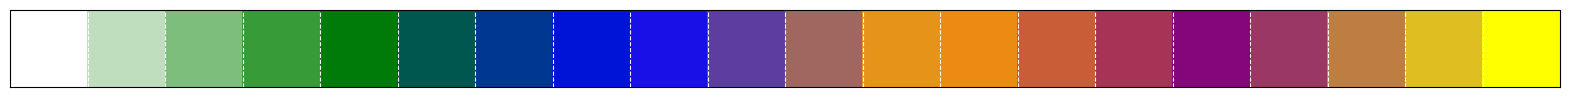

In [58]:
sess_colors = ['white','green','blue','orange','purple','yellow']
# Number of colors needed in the spectrum
num_colors = 20
sess_fill = sns.blend_palette(sess_colors, n_colors=num_colors, as_cmap=False)
sns.palplot(sess_fill)
plt.show()
# colors2rep = bar_fill[9:12]#[5:8]
# color_patt = colors2rep*6
# sns.palplot(color_patt)

set1 = [1,5]
set2 = [8,9]
set3 = [12,13]
set4 = [18,17]

s_color = [set1,set2,set3,set4]

### *Set Fixed Parameters for  Hyperbolic Ratio / Naka Rushton Fits*

In [59]:
# experimental conditions if interest 
Condition_Label = ['Pot, A+', 'Non-Pot, A-', 'Pot, A-', 'Non-Pot, A+'] 
SessionDelay_Label = ['1-2 Days','3-5 days','7-10 Days','12-37 Days']
# pre post induction labels
crf_label = ['pre','post']
# sweep contrast labels
contrast_labs = ['1%','2.5%','6.3%','15.8%','39.8%','100%']
# set colors for plotting 
color_set = [3,6,12,13]

In [60]:
# array for smoothing fit functions to CRF data 
ContrastArr = np.array(np.arange(0.0,100,0.1)) # all contrast from 1% - 100% - ~1k data points
ContrastEnd = (ContrastArr.shape[0])
print('length of x array for contrasts: ', ContrastArr.shape)

x1 = np.linspace(0, 100, 6) # all 6 contrasts (pre fit array)
x2 = np.linspace(0, 100, ContrastEnd) # all 100 contrasts (post-fit array for smoothing)
contrast_levels = [1,2.5,6.3,15.8,39.8,100]
param_names = ['C50','n','Rmax','b'] # naka rushton fit labels 

length of x array for contrasts:  (1000,)


In [61]:

# def naka_rushton_saturation(C,C50,n,Rmax,b,s):
#     """
#     This function models neural responses captured by Contrast Response Functions with 
#     1 extra parameter to fit supersaturating CRF towards higher contrasts
#     NOTE: The extra parameters means that all 4 values from this fit are DIFFERENT interpretations of original NR funct.
#      C50 (parameter 1) : Contrast level that yields half of max response (contrast %)
#     n (parameter 2)   : Determines the curve arc for fitting (small integer)
#     Rmax (Parameter 3): Max response elicited (mv)
#     b (Parameter 4)   : Starting value (origin)
#     s (Parameter 5)   : saturation index
#     """
#     return ((Rmax * (( C ** n) / ( C50 ** (s*n) + C ** (s*n)))) + b)

In [62]:
# dataIn = PrePostConditionData[0] #[38,2,6]
# # [38, 2]
# PrePost_SaturationValues = np.zeros((int(dataIn.shape[0]),2)) #[subjx xsaturation index values]  # saturation index evaluation
# # [38,2]
# PrePost_SaturationValues_LocInstance = np.zeros((int(dataIn.shape[0]),2)) #[subj x saturation index values] # where saturation occured

# for CRF_SaturationEval in range(2):#range(dataIn.shape[0]): # iterate through all subjects
#     for prepost in range(2): # iterate through pre post crfs

#         crf_data = dataIn[CRF_SaturationEval,prepost] # import 1 crf per iter (6 contrasts)

#         MaxResponseLoc = np.argmax(crf_data) # find where maximum response is
#         MaxResponseVal = crf_data[np.argmax(crf_data)] # find what ax response was given the locaiton

#         # compute saturation index
#         Response_at_100 = crf_data[5] # response at 100% contrast
#         pseudo_C50 = crf_data[3] # reponse at 60% contrast, not 40% or 50% (we dont have 50% :())
#         #SI_response_change = (Response_at_100 - pseudo_C50)/ MaxResponseVal # Saturation Index Computation (Ledgeway et al. 2005) 
#         PrePost_SaturationValues[CRF_SaturationEval,prepost] = (Response_at_100 - pseudo_C50)/ MaxResponseVal #store satruation index 
#         PrePost_SaturationValues_LocInstance[CRF_SaturationEval,prepost] = MaxResponseLoc # store contrast with saturation index  
# print(PrePost_SaturationValues_LocInstance)

In [63]:
# def SaturationFix_CRF(crf,SI):
#     """This function detects rmax value and location, and replaces the crf values for saturating data
#     crf = contrast response function data (len 4, subj x prepost x sweep data)
#     SI = saturation index (len 4)
#     """
#     DataIn = np.array(crf) # pre post contrast repsonse functions 
#     SI_In = np.array(SI) # saturation index for pre post

#     DataOut = np.zeros_like(DataIn)

#     for x in range(DataIn.shape[0]):
#         for prepost in range(2):
#             if SI_In[x,prepost] == 1:
#                 crf_rmax = np.max(DataIn[x,prepost])
#                 crf_rmax_pos = np.argmax(DataIn[x,prepost])
#                 DataOut[x,prepost,0:crf_rmax_pos] = DataIn[x,prepost,0:crf_rmax_pos]
#                 DataOut[x,prepost,crf_rmax_pos:] = crf_rmax
#             else:
#                 DataOut[x,prepost,:] = DataIn[x,prepost]

#     return DataOut

### *Import Processed, Normalized Contrast Response Function Data and sort*

In [64]:
# indexing certain harmonics ,,,, note sure if this does anything here tho 
# Harmonic_Range_To_Include = np.arange(0,2)
# NR_Harmonic_Range = Harmonic_Range_To_Include
# FirstIndex = int(NR_Harmonic_Range[0])
# LastIndex = int(NR_Harmonic_Range [1] + 1)

In [65]:
# subject names and arrays to index attnL and attnR expts
File_Pos = loadData['File_Location_Indicies']
SessionDelayArr = loadData['SessionDelayGroups']
# subject array indexing location for 1st sesison completed and 2nd sesison completed
File_Pos_ChronologTime = loadData['File_Location_ChronologicalTime']
Subj_Ids = loadData['Subj_Num_Ids']
# clean pre post CRF's
# F1_Responses = loadData['F1_Norm_CRF']
# F2_Responses = loadData['F2_Norm_CRF']
# print(len(F1_Responses),len(F2_Responses))
# Original CRF's
F1_Responses = loadData['F1_CRF']
F2_Responses = loadData['F2_CRF']
print(len(F1_Responses),len(F2_Responses))

66 66


In [66]:
AttnX_Indicies =  loadData['ChronoTime_EAttn_xptSessionCondtion']
'show session order 1st then 2nd visit and show what delay group they belong in' 
# print(AttnX_Indicies)
# print(SessionDelayArr)

'show session order 1st then 2nd visit and show what delay group they belong in'

In [67]:
# serve as empty arrays for files that do not exist (ie: second sesion)
crf_nans = np.zeros((4,2,6))
diff_nans = np.zeros((4,6))
crf_nans[:] = np.nan
diff_nans[:] = np.nan

#### **Enter what type of file positon to investigate**

In [68]:
#File_Pos  = to  sort data by attnL and then attnR
#File_Pos_ChronologTime  = to sort data based on what session was completed first
#File_Index = File_Pos_ChronologTime
if Method == 'Order':
    File_Index = File_Pos_ChronologTime
if Method == 'AttnDeplyment':
    File_Index = File_Pos
    
print(Method)
# print(File_Index)

Order


### **Combine File Positon and Data Grouping!**

In [69]:
Subject_DataGrouping = np.concatenate((File_Index,SessionDelayArr),axis = 1)
'Subject_DataGrouping[:,0]== 1st session file position'
'Subject_DataGrouping[:,0]== 2nd session file position'
'Subject_DataGrouping[:,0]== SessionReturn Delay group they belong to'
'visual inspection that everything was done correctly'
print(Subject_DataGrouping)

[[ 0.  1.  1.]
 [ 2.  3.  2.]
 [ 4.  5.  1.]
 [ 6.  7.  2.]
 [ 8.  9.  2.]
 [10. 11.  2.]
 [12. 13.  2.]
 [14. 15.  0.]
 [16. nan nan]
 [18. 17.  0.]
 [nan nan nan]
 [22. 21.  0.]
 [24. 23.  1.]
 [26. 25.  1.]
 [28. 27.  0.]
 [30. 29.  1.]
 [32. 31.  0.]
 [34. 33.  3.]
 [35. 36.  0.]
 [38. 37.  1.]
 [39. 40.  1.]
 [nan 41. nan]
 [43. 42.  0.]
 [nan 44. nan]
 [46. 45.  0.]
 [48. 47.  2.]
 [49. 50.  0.]
 [51. nan nan]
 [52. nan nan]
 [53. nan nan]
 [nan 54. nan]
 [55. nan nan]
 [57. 56.  3.]
 [58. nan nan]
 [59. nan nan]
 [60. 61.  3.]
 [62. 63.  0.]
 [64. 65.  3.]]


### **To remove subjects who only completed 1 session:**

In [70]:
# print(File_Index)
# Pre Exlusion logis. 
print(f'AttnL session counts: {np.sum(~np.isnan(File_Index[:,0]))}')
print(f'AttnR session counts: {np.sum(~np.isnan(File_Index[:,1]))}')

AttnL session counts: 34
AttnR session counts: 30


In [71]:
if Exclude_Single_Subjs == 'y':
    print(f'removing participants who only completed 1 session')
    # bool to rnm subjs who only completed 1 session
    propagate_NaNs = np.isnan(File_Index).any(axis = 1)
    print(np.sum(propagate_NaNs[:]))
    File_Index[propagate_NaNs] = np.nan
    AttnX_Indicies[propagate_NaNs] = np.nan
    print(f'Subjs Remaining for analysis: {np.sum(~np.isnan(File_Index[:,0]))}')

removing participants who only completed 1 session
11
Subjs Remaining for analysis: 27


In [72]:
# sort! 
CRF_IndividualResponses_Sorted = []

for iter in range(len(Subj_Ids)):

    Subj_Title = Subj_Ids[iter] # subject 
    Indiv_File_Locations = File_Index[iter,:] # import file locations for data
    AttendL_Condition = Indiv_File_Locations[0] # attnL file
    AttendR_Condition = Indiv_File_Locations[1] # attnR file

    # If both locations contain NaNs, replace all data
    if np.isnan(AttendL_Condition) and np.isnan(AttendR_Condition):
        CRF_Set = [crf_nans, crf_nans, crf_nans, crf_nans]
        #print('Both AttnL and AttnR files are missing, now replacing all data ...')
        #print(Indiv_File_Locations)
    # If the first position contains a NaN, replace with NaN data for F1 and F2
    elif np.isnan(AttendL_Condition):
        #print('Attn L file is missing, now replacing ...')
        #print(Indiv_File_Locations)
        CRF_Set = [crf_nans, crf_nans, F1_Responses[int(AttendR_Condition)], F2_Responses[int(AttendR_Condition)]]
    # If the second position contains a NaN, replace with NaN data for F1 and F2
    elif np.isnan(AttendR_Condition):
        #print('Attn R file is missing, now replacing ...')
        #print(Indiv_File_Locations)
        CRF_Set = [F1_Responses[int(AttendL_Condition)], F2_Responses[int(AttendL_Condition)], crf_nans, crf_nans]
    else:
        #print('Both AttnL and AttnR files are present.')
        #print(Indiv_File_Locations)
        CRF_Set = [F1_Responses[int(AttendL_Condition)], F2_Responses[int(AttendL_Condition)], F1_Responses[int(AttendR_Condition)], F2_Responses[int(AttendR_Condition)]]
        
    CRF_IndividualResponses_Sorted.append(CRF_Set)

In [73]:
s1s1_Data = {} # segment data for 1st and 2nd visit

for CoX in range(4):
    s1s1_Data[CoX] = CombinePrePostResponses(DataIn = CRF_IndividualResponses_Sorted, Cond2Import = int(CoX), HarmonicIndex = 0)

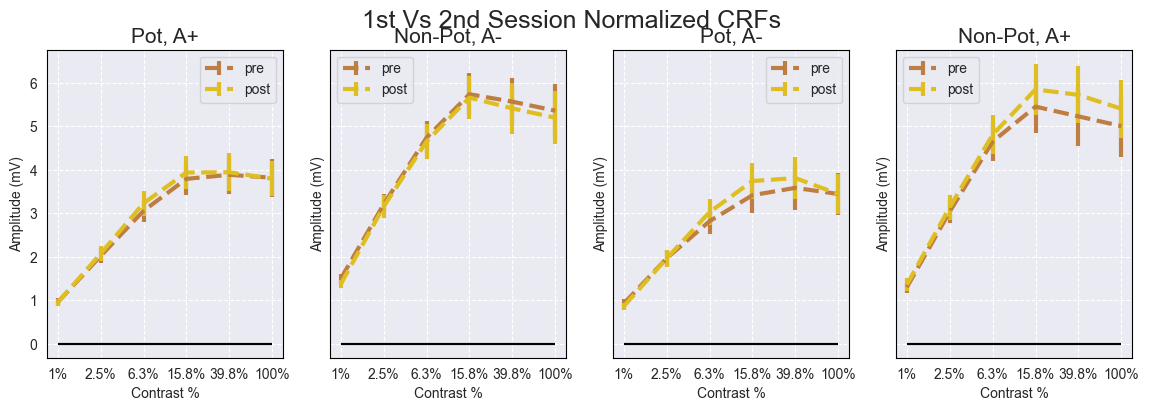

In [74]:
fig,axs = plt.subplots(1,4,figsize = ((14,4)), sharey = True)
Title = '1st Vs 2nd Session Normalized CRFs'
prepostPal = 17
for x in range(4):
    condition = np.array(s1s1_Data[x])
    NumObvs = np.sqrt(np.count_nonzero(~np.isnan(condition[:,0,0]))) # get number of subjs
    for prepost in range(2):
        prepost_avgs = np.nanmean(condition[:,prepost,:],axis = 0)
        prepost_stds = np.nanstd(condition[:,prepost,:],axis = 0) / NumObvs
        #axs[x].plot(prepost_avgs, label =crf_label[prepost], color = fill[9+prepost])
        #axs[x].errorbar(np.arange(0,6,1),prepost_avgs,yerr = prepost_stds,linestyle='--',label =crf_label[prepost], color = fill[13-prepost], linewidth = 2)
        axs[x].errorbar(np.arange(0,6,1),prepost_avgs,yerr = prepost_stds,linestyle='--',label =crf_label[prepost], color = sess_fill[prepostPal+prepost], linewidth = 3)
        axs[x].set_title(f'{Condition_Label[x]}',fontsize = 15)
        axs[x].set_ylabel(f'Amplitude (mV)')
        axs[x].set_xlabel(f'Contrast %')
        axs[x].set_xticks(ticks = np.arange(0,6,1),labels = contrast_labs)
        axs[x].hlines(0,xmin = 0,xmax = 5, color = 'black')
        axs[x].legend()
    plt.suptitle(f'{Title}', fontsize = 18)

In [75]:
# print(AttnX_Indicies.shape)
# print(File_Index.shape)

#### **Vizualize Data Based on 1st VS 2nd Session Visit Performance, Attention Deployment Exposure**

In [76]:
def Get_X_SessionData(AttnX_Indicies,File_Index,crf_nans,SessionDay):

    SessionData_Locs = []
    #crf_nans
    for attnF in range(File_Index.shape[0]):
        SessionImport = AttnX_Indicies[attnF,SessionDay] # import session value 
        SessionFileLocs = File_Index[attnF,SessionDay] # import sesison file positon
        #print(SessionImport,SessionFileLocs)
        if np.isnan(SessionFileLocs):
            print(f'session does not exist')
            ds_set = [crf_nans,crf_nans,crf_nans,crf_nans]
            SessionData_Locs.append(ds_set)
        else:
        # #print(f'{SessionImport},{SessionFileLocs}')
            if SessionImport == 100:
                print('Attend Left session was first exposure to task')
                ds_set = [F1_Responses[int(SessionFileLocs)],F2_Responses[int(SessionFileLocs)],crf_nans,crf_nans]
                SessionData_Locs.append(ds_set)
            if SessionImport == 200:
                print('Attend Right session was first exposure to task')
                ds_set = [crf_nans,crf_nans, F1_Responses[int(SessionFileLocs)],F2_Responses[int(SessionFileLocs)]]
                SessionData_Locs.append(ds_set)
        
    return SessionData_Locs

In [77]:
Sess1_AttnExposure = Get_X_SessionData(AttnX_Indicies,File_Index,crf_nans,SessionDay = 0)
Sess2_AttnExposure = Get_X_SessionData(AttnX_Indicies,File_Index,crf_nans,SessionDay = 1)
print(len(Sess1_AttnExposure))
print(len(Sess2_AttnExposure))

Attend Left session was first exposure to task
Attend Left session was first exposure to task
Attend Left session was first exposure to task
Attend Left session was first exposure to task
Attend Left session was first exposure to task
Attend Left session was first exposure to task
Attend Left session was first exposure to task
Attend Left session was first exposure to task
session does not exist
Attend Right session was first exposure to task
session does not exist
Attend Right session was first exposure to task
Attend Right session was first exposure to task
Attend Right session was first exposure to task
Attend Right session was first exposure to task
Attend Right session was first exposure to task
Attend Right session was first exposure to task
Attend Right session was first exposure to task
Attend Left session was first exposure to task
Attend Right session was first exposure to task
Attend Left session was first exposure to task
session does not exist
Attend Right session was firs

##### ***Combine Data Based on attentional deployment based on exposure***
#### **Group Data by Condition:  [subj x prepost x sweep]**

In [78]:
sess1AttnX = {} # attn deployment for 1st session

for CoX in range(4):
    sess1AttnX[CoX] = CombinePrePostResponses(DataIn = Sess1_AttnExposure, Cond2Import = int(CoX), HarmonicIndex = 0)
    #print(sess1AttnX[CoX].shape)

In [79]:
sess2AttnX = {} # att deployment for 2nd session

for CoX in range(4):
    sess2AttnX[CoX] = CombinePrePostResponses(DataIn = Sess2_AttnExposure, Cond2Import = int(CoX), HarmonicIndex = 0)
    #print(sess1AttnX[CoX].shape)

In [80]:
def GetAttXSessXPlots(Data2Plot, Title, prepostPal):
    fig,axs = plt.subplots(1,4,figsize = ((14,4)), sharey = True)

    for x in range(4):
        condition = np.array(Data2Plot[x])
        NumObvs = np.sqrt(np.count_nonzero(~np.isnan(condition[:,0,0]))) # get number of subjs
        for prepost in range(2):
            prepost_avgs = np.nanmean(condition[:,prepost,:],axis = 0)
            prepost_stds = np.nanstd(condition[:,prepost,:],axis = 0) / NumObvs
            #axs[x].plot(prepost_avgs, label =crf_label[prepost], color = fill[9+prepost])
            #axs[x].errorbar(np.arange(0,6,1),prepost_avgs,yerr = prepost_stds,linestyle='--',label =crf_label[prepost], color = fill[13-prepost], linewidth = 2)
            axs[x].errorbar(np.arange(0,6,1),prepost_avgs,yerr = prepost_stds,linestyle='--',label =crf_label[prepost], color = sess_fill[prepostPal+prepost], linewidth = 3)
            axs[x].set_title(f'{Condition_Label[x]}',fontsize = 15)
            axs[x].set_ylabel(f'Amplitude (mV)')
            axs[x].set_xlabel(f'Contrast %')
            axs[x].set_xticks(ticks = np.arange(0,6,1),labels = contrast_labs)
            axs[x].hlines(0,xmin = 0,xmax = 5, color = 'black')
            axs[x].legend()
        plt.suptitle(f'{Title}', fontsize = 18)

    return axs

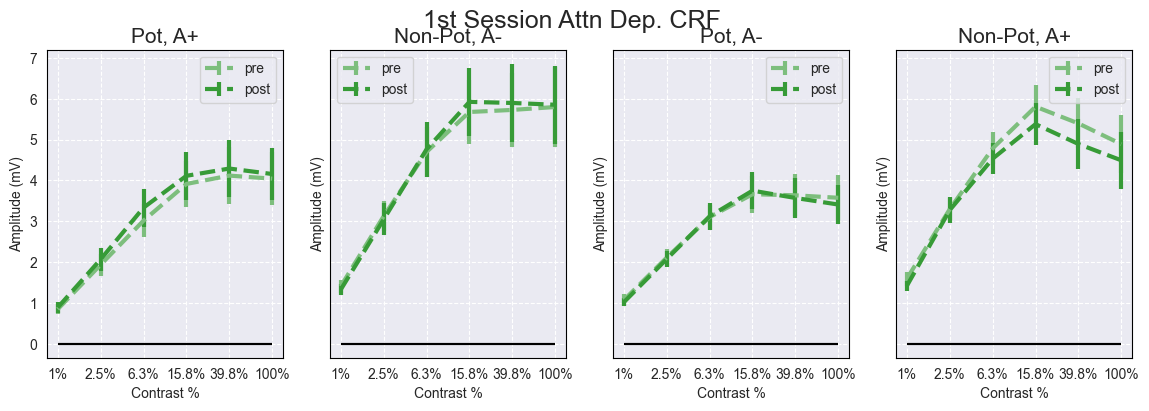

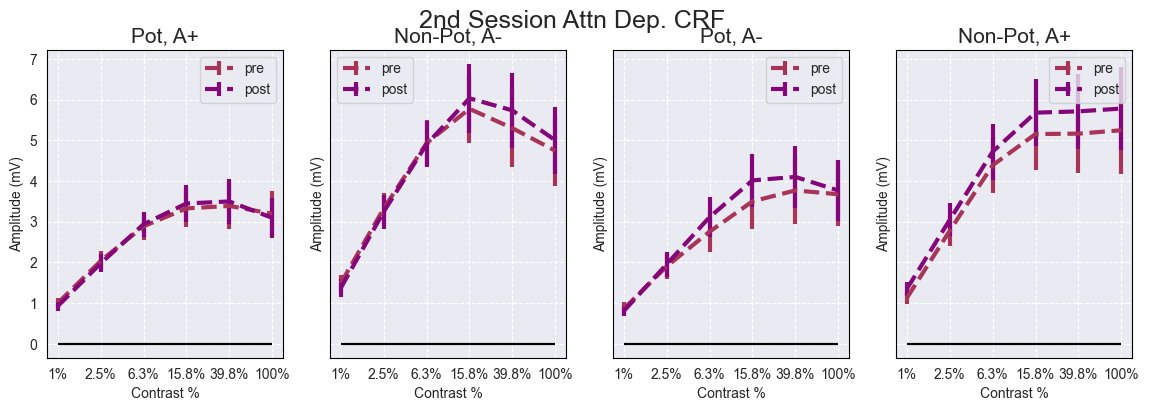

In [81]:
Sess1Performance = GetAttXSessXPlots(Data2Plot = sess1AttnX, Title = '1st Session Attn Dep. CRF', prepostPal = 2)
Sess2Performance = GetAttXSessXPlots(Data2Plot = sess2AttnX, Title = '2nd Session Attn Dep. CRF', prepostPal = 14)

#### **SORT ALL CONDITIONAL DATA Based on 1st and 2nd Session & Days Apart Group (immediate vs delayed)**

In [82]:
def SessionDelayProcessing(CombinePrePostResponses,File_Index,AttnX_Indicies,SessionDelayArr,s_color, DelayGroupIn = 0, Title = 'xshs'):
    SessionDelay_Locs_AttnX = [] # 1st session visit vs 2nd session

    for attnF in range(File_Index.shape[0]):
        SessionImport = AttnX_Indicies[attnF,:] # import session value (100 = L, 200 = R)
        What_DelayGroup = SessionDelayArr[attnF] # import delay session group subj is in 
        SessionFileLocs = File_Index[attnF,:] # import sessison file positon

        if What_DelayGroup == DelayGroupIn: # if subject belongs in delay goup we're interested in
            print(SessionFileLocs,SessionImport)

            chronTime_ds_set = [F1_Responses[int(SessionFileLocs[0])],F2_Responses[int(SessionFileLocs[0])],F1_Responses[int(SessionFileLocs[1])],F2_Responses[int(SessionFileLocs[1])]]
            SessionDelay_Locs_AttnX.append(chronTime_ds_set)

    DataGroupAttnX_Out = {}

    for CoX in range(4):

        DataGroupAttnX_Out[CoX] = CombinePrePostResponses(DataIn = SessionDelay_Locs_AttnX, Cond2Import = int(CoX), HarmonicIndex = 0)
        temp = np.sum(~np.isnan(DataGroupAttnX_Out[CoX][:,0,0]))
        print(f'Subjects Included in Analysis: #{temp}')
        print(DataGroupAttnX_Out[CoX].shape)


    fig,axs = plt.subplots(1,4,figsize = ((14,4)), sharey = True)
    s_colorIn = (s_color[DelayGroupIn])
# print(s_colorIn)

    for x in range(4):
        condition = np.array(DataGroupAttnX_Out[x])
        # print(condition.shape)
        NumObvs = np.sqrt(np.count_nonzero(~np.isnan(condition[:,0,0]))) # get number of subjs
        print(np.sum(~np.isnan(condition[:,0,0]))) # see number of subjects per condition
        for prepost in range(2):
            prepost_avgs = np.nanmean(condition[:,prepost,:],axis = 0)
            prepost_stds = np.nanstd(condition[:,prepost,:],axis = 0) / NumObvs
        #     #axs[x].plot(prepost_avgs, label =crf_label[prepost], color = fill[9+prepost])
        #     #axs[x].errorbar(np.arange(0,6,1),prepost_avgs,yerr = prepost_stds,linestyle='--',label =crf_label[prepost], color = fill[13-prepost], linewidth = 2)
            axs[x].errorbar(np.arange(0,6,1),prepost_avgs,yerr = prepost_stds,linestyle='--',label =crf_label[prepost], color = sess_fill[s_colorIn[prepost]], linewidth = 3) # color = fill[17+prepost]
            axs[x].set_title(f'{Condition_Label[x]}',fontsize = 15)
            axs[x].set_ylabel(f'Amplitude (mV)')
            axs[x].set_xlabel(f'Contrast %')
            axs[x].set_xticks(ticks = np.arange(0,6,1),labels = contrast_labs)
            axs[x].hlines(0,xmin = 0,xmax = 5, color = 'black')
            axs[x].legend()
        #plt.suptitle(f'1st SessionAttn Dep. CRF', fontsize = 10)
        plt.suptitle(f'{Title}: 1st vs 2nd Session CRF', fontsize = 10)

    return axs

# print(len(SessionDelay_Locs_AttnX)) # sessions grouped based on 1st | 2nd visit 

[14. 15.] [100. 200.]
[18. 17.] [200. 100.]
[22. 21.] [200. 100.]
[28. 27.] [200. 100.]
[32. 31.] [200. 100.]
[35. 36.] [100. 200.]
[43. 42.] [200. 100.]
[46. 45.] [200. 100.]
[49. 50.] [100. 200.]
[62. 63.] [100. 200.]
Subjects Included in Analysis: #10
(10, 2, 6)
Subjects Included in Analysis: #10
(10, 2, 6)
Subjects Included in Analysis: #10
(10, 2, 6)
Subjects Included in Analysis: #10
(10, 2, 6)
10
10
10
10
[0. 1.] [100. 200.]
[4. 5.] [100. 200.]
[24. 23.] [200. 100.]
[26. 25.] [200. 100.]
[30. 29.] [200. 100.]
[38. 37.] [200. 100.]
[39. 40.] [100. 200.]
Subjects Included in Analysis: #7
(7, 2, 6)
Subjects Included in Analysis: #7
(7, 2, 6)
Subjects Included in Analysis: #7
(7, 2, 6)
Subjects Included in Analysis: #7
(7, 2, 6)
7
7
7
7
[2. 3.] [100. 200.]
[6. 7.] [100. 200.]
[8. 9.] [100. 200.]
[10. 11.] [100. 200.]
[12. 13.] [100. 200.]
[48. 47.] [200. 100.]
Subjects Included in Analysis: #6
(6, 2, 6)
Subjects Included in Analysis: #6
(6, 2, 6)
Subjects Included in Analysis: #6
(6

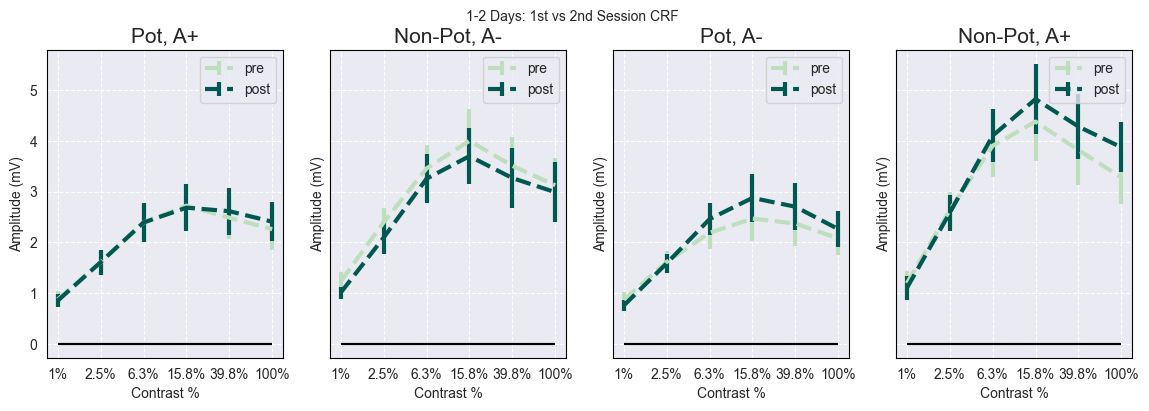

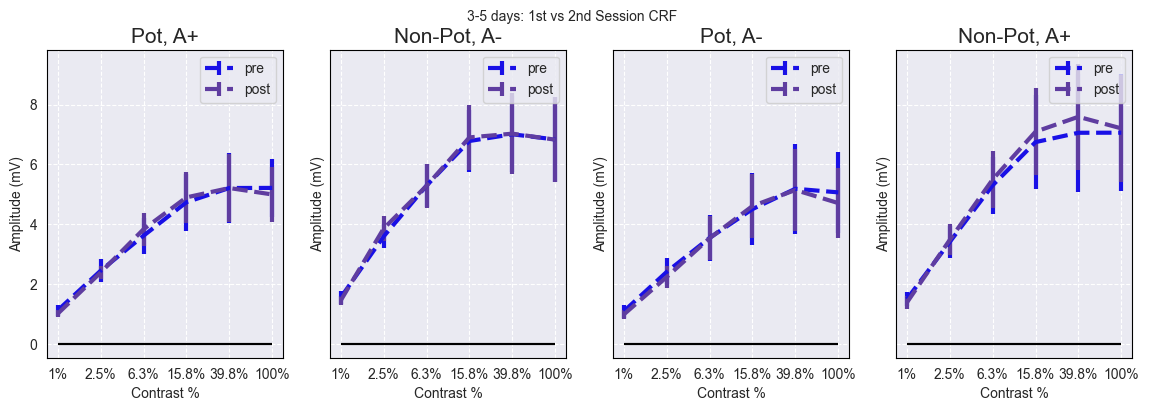

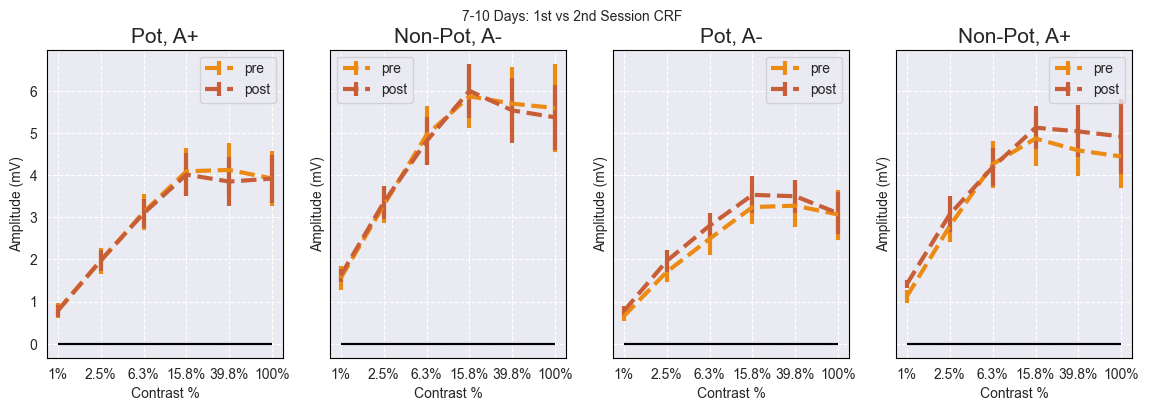

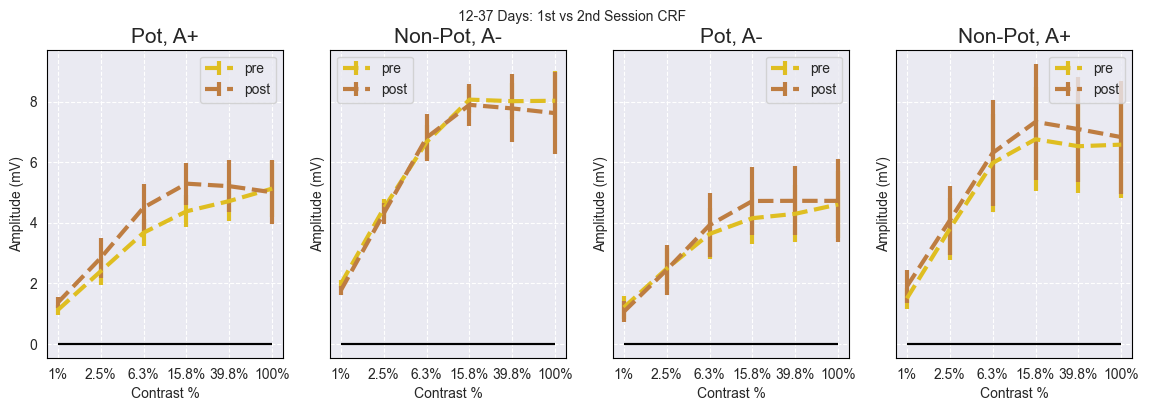

In [83]:
for SessDelay_Plt in range(4):  

    PltCond = SessionDelayProcessing(CombinePrePostResponses,File_Index,AttnX_Indicies,SessionDelayArr,s_color, DelayGroupIn = SessDelay_Plt, Title = SessionDelay_Label[SessDelay_Plt])

## ****Normalize CRF Based on 1st Pre CRF****

In [98]:
Harmonic2Normalize = 1

In [99]:
NormalizedOut = []

for subj in range(len(CRF_IndividualResponses_Sorted)):
    Normalized2Pre4Sess1 = []
    for AllSessDataperSubj in range(4):
        dImport = CRF_IndividualResponses_Sorted[subj][AllSessDataperSubj] # [4x2x6]

        if AllSessDataperSubj == 0: # acess 1st session response pre induction for left hemifield (inducting)
            MaxPre = np.max(dImport[Harmonic2Normalize,0,:])
            #print(f'getting max response during pre induction, 1st session for subj {subj}, {MaxPre}')

        Normalized_DataOut = dImport[Harmonic2Normalize,:,:] / MaxPre
        Normalized2Pre4Sess1.append(Normalized_DataOut)

    NormalizedOut.append(Normalized2Pre4Sess1)

In [100]:
PreS1_NormData = []
for x in range(4):
    temp = CombinePrePostResponses_PreS1Norm(DataIn = NormalizedOut,CoX = x)
    PreS1_NormData.append(temp)

(38, 2, 6)
(38, 2, 6)
(38, 2, 6)
(38, 2, 6)


In [101]:
DelayGroupIn = 0

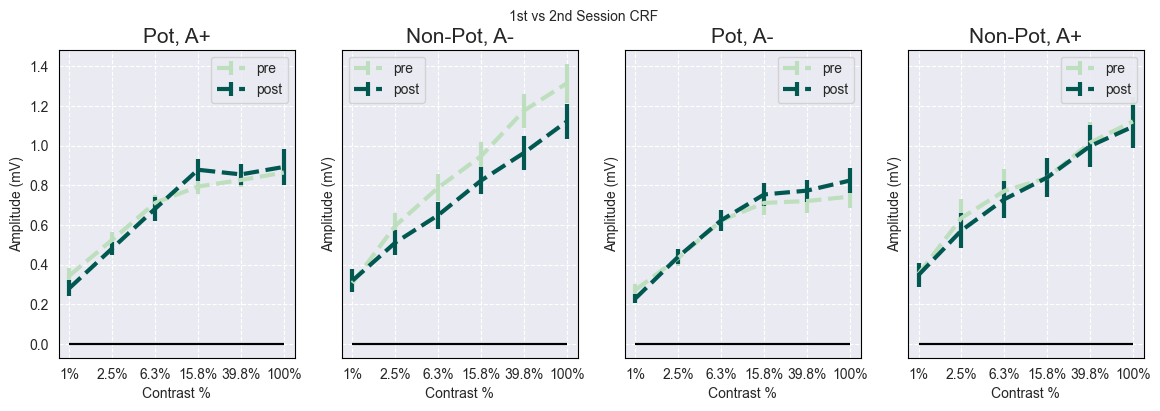

In [102]:
fig,axs = plt.subplots(1,4,figsize = ((14,4)), sharey = True)
s_colorIn = (s_color[DelayGroupIn])

for x in range(4):
    condition = np.array(PreS1_NormData[x])
    NumObvs = np.sqrt(np.count_nonzero(~np.isnan(condition[:,0,0]))) # get number of subjs
    #print(np.sum(~np.isnan(condition[:,0,0]))) # see number of subjects per condition
    for prepost in range(2):
        prepost_avgs = np.nanmean(condition[:,prepost,:],axis = 0)
        prepost_stds = np.nanstd(condition[:,prepost,:],axis = 0) / NumObvs
    # #     #axs[x].plot(prepost_avgs, label =crf_label[prepost], color = fill[9+prepost])
    # #     #axs[x].errorbar(np.arange(0,6,1),prepost_avgs,yerr = prepost_stds,linestyle='--',label =crf_label[prepost], color = fill[13-prepost], linewidth = 2)
        axs[x].errorbar(np.arange(0,6,1),prepost_avgs,yerr = prepost_stds,linestyle='--',label =crf_label[prepost], color = sess_fill[s_colorIn[prepost]], linewidth = 3) # color = fill[17+prepost]
        axs[x].set_title(f'{Condition_Label[x]}',fontsize = 15)
        axs[x].set_ylabel(f'Amplitude (mV)')
        axs[x].set_xlabel(f'Contrast %')
        axs[x].set_xticks(ticks = np.arange(0,6,1),labels = contrast_labs)
        axs[x].hlines(0,xmin = 0,xmax = 5, color = 'black')
        axs[x].legend()
    #plt.suptitle(f'1st SessionAttn Dep. CRF', fontsize = 10)
    plt.suptitle(f'1st vs 2nd Session CRF', fontsize = 10)

#### ****End of workbench - need to fit somehwere else ...****

In [ ]:
dd = ee

In [ ]:

    #print(SessionImport,SessionFileLocs)
    # if np.isnan(SessionFileLocs):
    #     print(f'session does not exist')
    #     ds_set = [crf_nans,crf_nans,crf_nans,crf_nans]
    #     SessionData_Locs.append(ds_set)
    # else:
    # # #print(f'{SessionImport},{SessionFileLocs}')
    #     if SessionImport == 100:
    #         print('Attend Left session was first exposure to task')
    #         ds_set = [F1_Responses[int(SessionFileLocs)],F2_Responses[int(SessionFileLocs)],crf_nans,crf_nans]
    #         SessionData_Locs.append(ds_set)
    #     elif SessionImport == 200:
    #         print('Attend Right session was first exposure to task')
    #         ds_set = [crf_nans,crf_nans, F1_Responses[int(SessionFileLocs)],F2_Responses[int(SessionFileLocs)]]
    #         SessionData_Locs.append(ds_set)

In [ ]:
print(np.unique(SessionDelayArr,return_counts = True))# [38] - array of 0-4
print(len(SessionDelay_Locs_AttnX))

In [ ]:
# DataGroupAttnX_Out = {}

# for CoX in range(4):

#     DataGroupAttnX_Out[CoX] = CombinePrePostResponses(DataIn = SessionDelay_Locs_AttnX, Cond2Import = int(CoX), HarmonicIndex = 0)
#     temp = np.sum(~np.isnan(DataGroupAttnX_Out[CoX][:,0,0]))
#     print(f'Subjects Included in Analysis: #{temp}')
#     print(DataGroupAttnX_Out[CoX].shape)

#### **Plot CRF based on 1st vs 2nd session, not attn dependent**

In [ ]:
# fig,axs = plt.subplots(1,4,figsize = ((14,4)), sharey = True)
# s_colorIn = (s_color[DelayGroupIn])
# print(s_colorIn)

# for x in range(4):
#     condition = np.array(DataGroupAttnX_Out[x])
#     # print(condition.shape)
#     NumObvs = np.sqrt(np.count_nonzero(~np.isnan(condition[:,0,0]))) # get number of subjs
#     print(np.sum(~np.isnan(condition[:,0,0]))) # see number of subjects per condition
#     for prepost in range(2):
#         prepost_avgs = np.nanmean(condition[:,prepost,:],axis = 0)
#         prepost_stds = np.nanstd(condition[:,prepost,:],axis = 0) / NumObvs
#     #     #axs[x].plot(prepost_avgs, label =crf_label[prepost], color = fill[9+prepost])
#     #     #axs[x].errorbar(np.arange(0,6,1),prepost_avgs,yerr = prepost_stds,linestyle='--',label =crf_label[prepost], color = fill[13-prepost], linewidth = 2)
#         axs[x].errorbar(np.arange(0,6,1),prepost_avgs,yerr = prepost_stds,linestyle='--',label =crf_label[prepost], color = sess_fill[s_colorIn[prepost]], linewidth = 2) # color = fill[17+prepost]
#         axs[x].set_title(f'{Condition_Label[x]}',fontsize = 15)
#         axs[x].set_ylabel(f'Amplitude (mV)')
#         axs[x].set_xlabel(f'Contrast %')
#         axs[x].set_xticks(ticks = np.arange(0,6,1),labels = contrast_labs)
#         axs[x].hlines(0,xmin = 0,xmax = 5, color = 'black')
#         axs[x].legend()
#     #plt.suptitle(f'1st SessionAttn Dep. CRF', fontsize = 10)
#     plt.suptitle(f'1st vs 2nd Session CRF', fontsize = 10)

#### **Plot CRF based on 1st (attnL) vs 2nd session(attnR)**

In [ ]:
DataGroupAttnL_Out = {}

for CoX in range(4):

    DataGroupAttnL_Out[CoX] = CombinePrePostResponses(DataIn = SessionData_Locs_AttnL_1st, Cond2Import = int(CoX), HarmonicIndex = 0)
    temp = np.sum(~np.isnan(DataGroupAttnL_Out[CoX][:,0,0]))
    print(f'Subjects Included in Analysis: #{temp}')
    print(DataGroupAttnL_Out[CoX].shape)

In [ ]:
fig,axs = plt.subplots(1,4,figsize = ((14,4)), sharey = True)

for x in range(4):
    condition = np.array(DataGroupAttnL_Out[x])
    print(condition.shape)
    NumObvs = np.sqrt(np.count_nonzero(~np.isnan(condition[:,0,0]))) # get number of subjs
    print(np.sum(~np.isnan(condition[:,0,0]))) # see number of subjects per condition
    for prepost in range(2):
        prepost_avgs = np.nanmean(condition[:,prepost,:],axis = 0)
        prepost_stds = np.nanstd(condition[:,prepost,:],axis = 0) / NumObvs
    #     #axs[x].plot(prepost_avgs, label =crf_label[prepost], color = fill[9+prepost])
    #     #axs[x].errorbar(np.arange(0,6,1),prepost_avgs,yerr = prepost_stds,linestyle='--',label =crf_label[prepost], color = fill[13-prepost], linewidth = 2)
        axs[x].errorbar(np.arange(0,6,1),prepost_avgs,yerr = prepost_stds,linestyle='--',label =crf_label[prepost], color = sess_fill[s_colorIn[prepost]], linewidth = 2)
        axs[x].set_title(f'{Condition_Label[x]}',fontsize = 15)
        axs[x].set_ylabel(f'Amplitude (mV)')
        axs[x].set_xlabel(f'Contrast %')
        axs[x].set_xticks(ticks = np.arange(0,6,1),labels = contrast_labs)
        axs[x].hlines(0,xmin = 0,xmax = 5, color = 'black')
        axs[x].legend()
    #plt.suptitle(f'1st SessionAttn Dep. CRF', fontsize = 10)
    plt.suptitle(f'AtnnL vs AttnR Session CRF', fontsize = 10)

#### **Plot CRF based on 1st (attnR) vs 2nd session(attnL)**

In [ ]:
DataGroupAttnR_Out = {}

for CoX in range(4):

    DataGroupAttnR_Out[CoX] = CombinePrePostResponses(DataIn = SessionData_Locs_AttnR_1st, Cond2Import = int(CoX), HarmonicIndex = 0)
    temp = np.sum(~np.isnan(DataGroupAttnR_Out[CoX][:,0,0]))
    print(f'Subjects Included in Analysis: #{temp}')
    print(DataGroupAttnR_Out[CoX].shape)

In [ ]:
fig,axs = plt.subplots(1,4,figsize = ((14,4)), sharey = True)

for x in range(4):
    condition = np.array(DataGroupAttnR_Out[x])
    print(condition.shape)
    NumObvs = np.sqrt(np.count_nonzero(~np.isnan(condition[:,0,0]))) # get number of subjs
    print(np.sum(~np.isnan(condition[:,0,0]))) # see number of subjects per condition
    for prepost in range(2):
        prepost_avgs = np.nanmean(condition[:,prepost,:],axis = 0)
        prepost_stds = np.nanstd(condition[:,prepost,:],axis = 0) / NumObvs
    #     #axs[x].plot(prepost_avgs, label =crf_label[prepost], color = fill[9+prepost])
        axs[x].errorbar(np.arange(0,6,1),prepost_avgs,yerr = prepost_stds,linestyle='--',label =crf_label[prepost], color = sess_fill[s_colorIn[prepost]], linewidth = 2)
        #axs[x].errorbar(np.arange(0,6,1),prepost_avgs,yerr = prepost_stds,linestyle='--',label =crf_label[prepost], color = fill[17+prepost], linewidth = 2)
        axs[x].set_title(f'{Condition_Label[x]}',fontsize = 15)
        axs[x].set_ylabel(f'Amplitude (mV)')
        axs[x].set_xlabel(f'Contrast %')
        axs[x].set_xticks(ticks = np.arange(0,6,1),labels = contrast_labs)
        axs[x].hlines(0,xmin = 0,xmax = 5, color = 'black')
        axs[x].legend()
    #plt.suptitle(f'1st SessionAttn Dep. CRF', fontsize = 10)
    plt.suptitle(f'AtnnR vs AttnL Session CRF', fontsize = 10)

### Workbench end ... code below should be modified ...

In [ ]:
pp = dd

In [ ]:
# SessionData_Locs = []
# #crf_nans
# for attnF in range(File_Index.shape[0]):
#     SessionImport = AttnX_Indicies[attnF,SessionDay] # import session value 
#     SessionFileLocs = File_Index[attnF,SessionDay] # import sesison file positon
#     #print(SessionImport,SessionFileLocs)
#     if np.isnan(SessionFileLocs):
#         print(f'session does not exist')
#         ds_set = [crf_nans,crf_nans,crf_nans,crf_nans]
#         SessionData_Locs.append(ds_set)
#     else:
#     # #print(f'{SessionImport},{SessionFileLocs}')
#         if SessionImport == 100:
#             print('Attend Left session was first exposure to task')
#             ds_set = [F1_Responses[int(SessionFileLocs)],F2_Responses[int(SessionFileLocs)],crf_nans,crf_nans]
#             SessionData_Locs.append(ds_set)
#         if SessionImport == 200:
#             print('Attend Right session was first exposure to task')
#             ds_set = [crf_nans,crf_nans, F1_Responses[int(SessionFileLocs)],F2_Responses[int(SessionFileLocs)]]
#             SessionData_Locs.append(ds_set)

In [ ]:
# print(len(SessionData_Locs))
# print((SessionData_Locs[0][0].shape))

# sess1AttnX = {}

# for CoX in range(4):
#     sess1AttnX[CoX] = CombinePrePostResponses(DataIn = SessionData_Locs, Cond2Import = int(CoX), HarmonicIndex = 0)
#     print(sess1AttnX[CoX].shape)

In [ ]:
fig,axs = plt.subplots(1,4,figsize = ((14,4)), sharey = True)

for x in range(4):
    condition = np.array(sess1AttnX[x])
    print(condition.shape)
    NumObvs = np.sqrt(np.count_nonzero(~np.isnan(condition[:,0,0]))) # get number of subjs
    for prepost in range(2):
        prepost_avgs = np.nanmean(condition[:,prepost,:],axis = 0)
        prepost_stds = np.nanstd(condition[:,prepost,:],axis = 0) / NumObvs
        #axs[x].plot(prepost_avgs, label =crf_label[prepost], color = fill[9+prepost])
        #axs[x].errorbar(np.arange(0,6,1),prepost_avgs,yerr = prepost_stds,linestyle='--',label =crf_label[prepost], color = fill[13-prepost], linewidth = 2)
        axs[x].errorbar(np.arange(0,6,1),prepost_avgs,yerr = prepost_stds,linestyle='--',label =crf_label[prepost], color = fill[17+prepost], linewidth = 2)
        axs[x].set_title(f'{Condition_Label[x]}',fontsize = 15)
        axs[x].set_ylabel(f'Amplitude (mV)')
        axs[x].set_xlabel(f'Contrast %')
        axs[x].set_xticks(ticks = np.arange(0,6,1),labels = contrast_labs)
        axs[x].hlines(0,xmin = 0,xmax = 5, color = 'black')
        axs[x].legend()
    #plt.suptitle(f'1st SessionAttn Dep. CRF', fontsize = 10)
    plt.suptitle(f'2nd Session Attn Dep. CRF', fontsize = 10)


##### **SORT ALL DATA**

In [ ]:
# sort! 
CRF_IndividualResponses_Sorted = []
# ExptCondition+Label = []

for iter in range(len(Subj_Ids)):

    Subj_Title = Subj_Ids[iter] # subject 
    Indiv_File_Locations = File_Index[iter,:] # import file locations for data
    AttendL_Condition = Indiv_File_Locations[0] # attnL file
    AttendR_Condition = Indiv_File_Locations[1] # attnR file

    # If both locations contain NaNs, replace all data
    if np.isnan(AttendL_Condition) and np.isnan(AttendR_Condition):
        CRF_Set = [crf_nans, crf_nans, crf_nans, crf_nans]
        print('Both AttnL and AttnR files are missing, now replacing all data ...')
        print(Indiv_File_Locations)
    # If the first position contains a NaN, replace with NaN data for F1 and F2
    elif np.isnan(AttendL_Condition):
        print('Attn L file is missing, now replacing ...')
        print(Indiv_File_Locations)
        CRF_Set = [crf_nans, crf_nans, F1_Responses[int(AttendR_Condition)], F2_Responses[int(AttendR_Condition)]]
    # If the second position contains a NaN, replace with NaN data for F1 and F2
    elif np.isnan(AttendR_Condition):
        print('Attn R file is missing, now replacing ...')
        print(Indiv_File_Locations)
        CRF_Set = [F1_Responses[int(AttendL_Condition)], F2_Responses[int(AttendL_Condition)], crf_nans, crf_nans]
    else:
        print('Both AttnL and AttnR files are present.')
        print(Indiv_File_Locations)
        CRF_Set = [F1_Responses[int(AttendL_Condition)], F2_Responses[int(AttendL_Condition)], F1_Responses[int(AttendR_Condition)], F2_Responses[int(AttendR_Condition)]]
        
    CRF_IndividualResponses_Sorted.append(CRF_Set)

#### *Should have 4 indices, each for : Pot Attn Cong, NonPot Attn Congr, Pot Attn Incong, NonPot Attn Incong*

In [ ]:
print(len(CRF_IndividualResponses_Sorted)) # [subject , 4 condtions, harmonic, prepost , contrast]
print(len(CRF_IndividualResponses_Sorted[0])) # 1 subjects perfomrance for boht sessions for each hemisphere
print((CRF_IndividualResponses_Sorted[0][0].shape)) # Harmonic CRF, PrePost Values, Response per sweep

In [ ]:
# for i in range(len(CRF_IndividualResponses_Sorted)):
#     vistest = CRF_IndividualResponses_Sorted[i][0]
#     print(i,vistest[0,0,4])

### *Combine CRF's into a single array, for a single harmonic at a time*

In [ ]:
# HarmonicValIn = 0

In [ ]:
PrePostConditionData = {}
for CondX in range(4):
    PrePostConditionData[CondX] = CombinePrePostResponses(DataIn = CRF_IndividualResponses_Sorted, Cond2Import = CondX, HarmonicIndex = HarmonicValIn)
    NaN_Bool = np.isnan(PrePostConditionData[CondX]).all(axis = (1,2))
    Remain_Subj_Count = PrePostConditionData[CondX][~NaN_Bool]
    print(f'Remaining subjs structure: Subj x PrePost x Sweep : {Remain_Subj_Count.shape}')

#### *Based on above, plot saturatation trend across Hemisphere for Attn-Congruent and Incongruent Condition*

In [ ]:
Vals = []  # saturation index response values 
SaturatingSweep = [] # location of where response is max 
RMaxResponseRecord = []
for CondX in range(4):
    CondX_Vals, CondX_SaturatingSweep, RMaxVals = Store_SaturationIndex_Information(dataIn = PrePostConditionData[CondX])
    Vals.append(CondX_Vals) # saturation index values 
    SaturatingSweep.append(CondX_SaturatingSweep) # position of max repsonse 
    RMaxResponseRecord.append(RMaxVals) # store response at highest contrast 

In [ ]:
print(Vals[0].shape)
print(Vals[0])

In [ ]:
fig,axs = plt.subplots(1,4,figsize = ((28,5)),sharey = True)

for coV in range(4):
    SI_Values_PrePost = np.array(Vals[coV])

    SI_label = ['pre','post']
    for i in range(SI_Values_PrePost.shape[1]):
        axs[coV].scatter(np.arange(0,SI_Values_PrePost.shape[0],1),SI_Values_PrePost[:,i],color = fill[9+i], label = SI_label[i])
        #plt.plot(SI_Values_PrePost[:,i],color = fill[9+i])
        axs[coV].hlines(0,xmin = 0,xmax = int(SI_Values_PrePost.shape[0]), color = fill[0])
        axs[coV].legend(loc = 'lower right')
        axs[coV].set_title(f'Saturation Index Cond: {Condition_Label[coV]}')

In [ ]:
# color_s = [0,5]
# for coV in range(4):
#     SI_Values_PrePost = np.array(Vals[coV])

#     fig,axs = plt.subplots(figsize = ((6,3)))
#     for i in range(SI_Values_PrePost.shape[1]):
#         axs.scatter(np.arange(0,SI_Values_PrePost.shape[0],1),SI_Values_PrePost[:,i],color = fill[color_s[i]], label = crf_label[i])
#         #plt.plot(SI_Values_PrePost[:,i],color = fill[color_s[i]])
#         axs.hlines(0,xmin = 0,xmax = int(SI_Values_PrePost.shape[0]), color = fill[0])
#         axs.legend(loc = 'lower right')
#         axs.set_title(f'Saturation Index Cond: {Condition_Label[coV]}')

In [ ]:
Saturation_Bool_group = []
Saturation_Counts = [] # wull use this index to identiy saturating CRF groups

for CondX in range(4): 
    sbg, sc = GetSaturationIndex_Bool(SaturationValuesIn = Vals[CondX], CRFs_In= PrePostConditionData[CondX])
    Saturation_Bool_group.append(sbg)
    Saturation_Counts.append(sc)

In [ ]:
# x_positions = np.array(np.arange(0,4,1))
Grand_SI = np.zeros((4*3))
Grand_EB = np.zeros_like((Grand_SI))

for Cx in range(4):
    ConditionChanges,ErrorEsts = SaturationIndex_3Fold(SaturationIndexScores = Vals[Cx])
    #print(ConditionChanges)
    Grand_SI[Cx*3:(Cx+1)*3] = ConditionChanges
    Grand_EB[Cx*3:(Cx+1)*3] = ErrorEsts


In [ ]:
bar_colors = ['red','white','green','white','purple','black']
# Number of colors needed in the spectrum
num_colors = 14
bar_fill = sns.blend_palette(bar_colors, n_colors=num_colors, as_cmap=False)
sns.palplot(bar_fill)
plt.show()
colors2rep = bar_fill[9:12]#[5:8]
color_patt = colors2rep*6
sns.palplot(color_patt)


In [ ]:
fig,axs = plt.subplots(figsize = ((12,5)))
bar_label = ['Pre','Post','Change'] * 4

bax_upperlabs =  [[Condition_Label[ i// 3]] for i in range(12)]

axs.hlines(0,xmin = 0,xmax = 12, color = 'black')
axs.bar(np.arange(0,12,1),Grand_SI, color = color_patt)
axs.errorbar(np.arange(0,12,1),Grand_SI, yerr=Grand_EB, fmt="*", color=bar_fill[0])
axs.set_xticks(np.arange(0,12,1), bar_label, rotation=45)

secax = axs.secondary_xaxis('top')
secax.set_xticks(np.arange(1.0, 12, 3))  # Adjust the position to be centered on the group
secax.set_xticklabels(Condition_Label)
# secax.set_xticks(np.arange(0,12,4))
# secax.set_xticklabels(bax_upperlabs[::4])
axs.set_title(f'Pre-Post-Induction SI Change per Hemifield',fontsize = 15)
axs.set_ylabel('SI Score Change')
plt.show()

#### Based on supersaturating reponses, fix responses based on rmax

In [ ]:
FixedSaturation_CRF = []
for x in range(4):
    # SaturationFixes = SaturationFix_CRF(crf = PrePostConditionData[x],SI = Saturation_Bool_group[x])
    SaturationFixes = SaturationFix_CRF(crf = PrePostConditionData[x],SI = Vals[x])
    FixedSaturation_CRF.append(SaturationFixes)

##### *Run Original NakaRushton with Non-Saturating, Normalized Contrast Response Functions*

In [ ]:
# get non-saturating CRFs to fit and derive values from 
nr_Group = []
norm_crf_Group = []

for CondX in range(4):
    #grouped_data = PrePostConditionData[CondX][Saturation_Subjs == 0,:,:] # No Saturation group, SI == 0
    #grouped_data = PrePostConditionData[CondX][Saturation_Subjs > 0,:,:] # Supersaturaton group, SI< 0 
    #grouped_data = PrePostConditionData[CondX] # Supersaturaton group, SI< 0 # ORIGINAL CRFS WITH SATURATION
    norm_crf_data = PrePostConditionData[CondX]
    grouped_data = FixedSaturation_CRF[CondX] # FIXED SATURATION DATA
    nr_Group.append(grouped_data)
    norm_crf_Group.append(norm_crf_data)

#### *Visualize Original Contrast Resonse Functions*

In [ ]:
fig,axs = plt.subplots(1,4,figsize = ((14,4)), sharey = True)

for x in range(4):
    condition = np.array(norm_crf_Group[x])
    print(condition.shape)
    NumObvs = np.sqrt(np.count_nonzero(~np.isnan(condition[:,0,0]))) # get number of subjs
    for prepost in range(2):
        prepost_avgs = np.nanmean(condition[:,prepost,:],axis = 0)
        prepost_stds = np.nanstd(condition[:,prepost,:],axis = 0) / NumObvs
        #axs[x].plot(prepost_avgs, label =crf_label[prepost], color = fill[9+prepost])
        axs[x].errorbar(np.arange(0,6,1),prepost_avgs,yerr = prepost_stds,label =crf_label[prepost], color = fill[9+prepost], linewidth = 2)
        axs[x].set_title(f'{Condition_Label[x]}')
        axs[x].set_ylabel(f'Amplitude (mV)')
        axs[x].set_xlabel(f'Contrast %')
        axs[x].set_xticks(ticks = np.arange(0,6,1),labels = contrast_labs)
        axs[x].hlines(0,xmin = 0,xmax = 5, color = 'black')
        axs[x].legend()
    plt.suptitle(f'original CRF', fontsize = 15)

#### *Visualize Fixed Saturation Contrast Response Functions*

In [ ]:
fig,axs = plt.subplots(1,4,figsize = ((14,4)), sharey = True)

for x in range(4):

    condition = np.array(FixedSaturation_CRF[x])
    #condition = np.array(nr_Group[x])
    NumObvs = np.sqrt(np.count_nonzero(~np.isnan(condition[:,0,0]))) # get number of subjs

    for prepost in range(2):
        prepost_avgs = np.nanmean(condition[:,prepost,:],axis = 0)
        prepost_stds = np.nanstd(condition[:,prepost,:],axis = 0) / NumObvs
        #axs[x].plot(prepost_avgs, label =crf_label[prepost], color = fill[9+prepost])
        axs[x].errorbar(np.arange(0,6,1),prepost_avgs,yerr = prepost_stds,label =crf_label[prepost], color = fill[9+prepost], linewidth = 2)
        axs[x].set_title(f'{Condition_Label[x]}')
        axs[x].set_ylabel(f'Amplitude (mV)')
        axs[x].set_xlabel(f'Contrast')
        axs[x].set_xticks(ticks = np.arange(0,6,1),labels = contrast_labs)
        axs[x].hlines(0,xmin = 0,xmax = 5, color = 'black')
        axs[x].legend()

plt.suptitle(f'Fixed Saturation CRF', fontsize = 15)

In [ ]:
# dummy data for pre-exisiting nan data (missing files)
emptyMat = np.zeros((1,4))
emptyMat[:] = np.nan

In [ ]:
AllCondition_FitParams = []

for nr_group_in in range(4):
    #nr_group_data = np.array(nr_Group[nr_group_in]) # original contrast repsonse functions 
    nr_group_data = np.array(FixedSaturation_CRF[nr_group_in]) # fixed saturation contrast repsonse functions 
    
    Fit_Params = np.zeros((nr_group_data.shape[0],2,4)) # [numsubs x prepost x fit outputs for hyperbolic ratio values]

    for subj in range(nr_group_data.shape[0]):
        for prepost in range(2):
            functs_In = nr_group_data[subj,prepost,:]
            if np.isnan(functs_In).all():
                #print(f'skipping this computation..., data not avilable: {subj,prepost}')
                Fit_Params[subj,prepost,:] = emptyMat
            else: 
                Fit_Params[subj,prepost,:], _ = curve_fit(naka_rushton,contrast_levels,functs_In,p0 = [20,0.05,1,0], bounds = boundaries,nan_policy='omit', method='trf')
    AllCondition_FitParams.append(Fit_Params)

In [ ]:
AllCondition_SmoothFits = []

for nr_group_in in range(4):
    nr_group_fitVals = np.array(AllCondition_FitParams[nr_group_in]) # params form curve fit
    SmoothFitsOut = np.zeros((nr_Group[nr_group_in].shape[0],2,int(len(ContrastArr)))) # empty array to make smooth fits

    for subjFitVals in range(nr_group_fitVals.shape[0]):
        for prepost in range(2):
            SmoothFits = np.array(nr_group_fitVals[subjFitVals,prepost,:]) # 4 values 
            SmoothFitsOut[subjFitVals,prepost,:] = naka_rushton(ContrastArr,SmoothFits[0],SmoothFits[1],SmoothFits[2],SmoothFits[3])
    AllCondition_SmoothFits.append(SmoothFitsOut)

In [ ]:
crf__loc_vals = np.array(contrast_levels) - 1

In [ ]:
# for subject in range(AllCondition_SmoothFits[0].shape[0]):
#     fig,axs = plt.subplots(1,4,figsize = ((16,4)),sharey = True)
#     for vx in range(4):
#         smoothfitsimports = np.array(AllCondition_SmoothFits[vx][subject,:,:])
#         #crfimports = np.array(nr_Group[vx][subject,:,:])
#         crfimports = np.array(FixedSaturation_CRF[vx][subject,:,:])
    
#         nr_fit_values = np.array(AllCondition_FitParams[vx][subject,:,:])
#         for prepost in range(2):
#             axs[vx].plot(x2,smoothfitsimports[prepost,:],color = fill[9+prepost])
#             axs[vx].scatter(contrast_levels, crfimports[prepost,:],color = fill[9+prepost],marker = 'o', linewidths = 1, s = 80,label = f'PRE: C50: {nr_fit_values[prepost,0]:.2f}, n:{nr_fit_values[prepost,1]:.2f},rMax:{nr_fit_values[prepost,2]:.2f}, B:{nr_fit_values[prepost,3]:.2f}')
#             axs[vx].set_title(f'{Condition_Label[vx]}')
#             axs[vx].set_ylabel(f'Amplitude (mV)')
#             axs[vx].set_xlabel(f'Contrast %')
#             axs[vx].hlines(0,xmin = 0,xmax = 100, color = 'black')

#         for x, y in zip(contrast_levels, crfimports[0,:]):
#             axs[vx].vlines(x, ymin=y-0.10, ymax=y+0.10, color=fill[9], linestyle='--', linewidth=1)

#         for x, y in zip(contrast_levels, crfimports[1,:]):
#             axs[vx].vlines(x, ymin=y-0.10, ymax=y+0.10, color=fill[10],linestyle='--', linewidth=1)

#             #legend = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
#             axs[vx].legend(loc = 'upper right',fontsize = 9,bbox_to_anchor=(1, -0.14))

#### *Visualize AllCondition_FitParams (naka rushton fit values)*

In [ ]:
fig,axs = plt.subplots(1,4,figsize = ((8,2)),sharey = True)

for ParamConds in range(4):
    nr_viz = AllCondition_FitParams[ParamConds]
    NumObvs = np.sqrt(np.count_nonzero(~np.isnan(nr_viz[:,0,0]))) # get number of subjs
    #print(nr_viz.shape) #[38 x 2 x 4]  = # 3rd Dim = [0] = C50,[1] = n , [2] = rMax, [3] = b
    #print(NumObvs)
    axs[ParamConds].scatter(np.arange(0,int(nr_viz.shape[0]),1),nr_viz[:,0,0], color = fill[0], label = 'Pre C50', alpha = 0.30)
    axs[ParamConds].scatter(np.arange(0,int(nr_viz.shape[0]),1),nr_viz[:,1,0], color = fill[3], label = 'Post C50', alpha = 0.80)

In [ ]:
paramVal_title = ['C50','n','rMax','b']
fig,axs = plt.subplots(1,4,figsize = ((12,5)),sharey = False)

for param_Val in range(4):
    for ParamConds in range(4):
        nr_viz = AllCondition_FitParams[ParamConds]
        NumObvs = np.sqrt(np.count_nonzero(~np.isnan(nr_viz[:,0,param_Val]))) # get number of subjs

        paramMeans = np.nanmean(nr_viz[:,:,param_Val],axis = 0)
        paramSTDS = np.nanstd(nr_viz[:,:,param_Val],axis = 0) / NumObvs

        # axs[1.0].errorbar( np.array(paramMeans), yerr = paramSTDS, color ='red', linewidth = 2)
        axs[param_Val].hlines(0,xmin = 0,xmax = 1, color = 'black')
        axs[param_Val].errorbar(np.arange(0,2,1),paramMeans, color = fill[ParamConds+9],yerr = paramSTDS, label = f'{Condition_Label[ParamConds]}', linewidth = 4)
        axs[param_Val].set_xticks(ticks = np.arange(0,2,1),labels = ['Pre','Post'], fontsize= 12)
        axs[param_Val].set_title(f'{paramVal_title[param_Val]}')

axs[3].legend(loc = 'lower right')

#### *Make Naka Rushton Dataframes for MANOVA*
### subtract response differences for each nr value

In [ ]:
print(len(AllCondition_FitParams))
print(AllCondition_FitParams[0].shape)

In [ ]:
test = AllCondition_FitParams[0][0,:,:]
print(test.shape)
fit_differenceValues = np.subtract(test[1,:],test[0,:])
print(fit_differenceValues)

In [ ]:
# groupIn = AllCondition_FitParams[3]
# print(groupIn[:,0,:].shape)
fig,axs = plt.subplots(figsize = ((10,8)))
sns.set_style("whitegrid")
sns.despine(left=True)
for xCond_Iters in range(4):
    groupIn = AllCondition_FitParams[xCond_Iters]

    NR_ValuesDiffs = np.subtract(groupIn[:,1,:], groupIn[:,0,:]) # post C50 - pre C50

    NumObvs = np.sqrt(np.count_nonzero(~np.isnan(NR_ValuesDiffs[:,0]))) # get number of subjs

    avgDiff = np.nanmean(NR_ValuesDiffs, axis = 0)
    avgSTD = np.nanstd(NR_ValuesDiffs, axis = 0) / NumObvs

    axs.errorbar(np.arange(0,4,1),avgDiff, color = fill[xCond_Iters+9],yerr = avgSTD,xerr = avgSTD, linewidth = 4, ls = 'none',label = Condition_Label[xCond_Iters]) # label = f'{Condition_Label[xCond_Iters]})
    axs.scatter(np.arange(0,4,1),avgDiff, facecolors = 'none', edgecolors = fill[xCond_Iters+9], s = 500, linewidths=5)

axs.set_xticks(ticks = np.arange(0,4,1),labels = ['C50','n', 'rMax', 'b'], fontsize= 12)
axs.hlines(0,xmin = 0,xmax = 3, color = 'black',label = 'No Change')
axs.set_title('Post Induction Naka Rushton Changes', fontsize = 20)
axs.set_ylabel(f'Reponse Change', fontsize = 15)
axs.set_xlabel(f'Naka Rushton Values', fontsize = 15)
axs.legend(loc = 'lower right', fontsize = 15)

#### *Make Dataframes for ANOVA*

In [ ]:
attnToArr = [0,0,1,1]
HemifArr = [0,1,0,1]

In [ ]:
NakaRushtonConditon_dfs = {}
for conds in range(4):
    NakaRushtonConditon_dfs[conds] = NakaRushtonDataFrames(condDataIn=AllCondition_FitParams[conds],HemiBool=attnToArr[conds],AttnBool=HemifArr[conds],subs=Subj_Ids)
    #print(len(NakaRushtonConditon_dfs[conds]))
    #NakaRushtonConditon_dfs.append(nr_dfs)

In [ ]:
headers = ['sID','Harmonic','attnTowards','hemifield', 'NR_Params','pre','post',]
print(headers)

In [ ]:
GoodSubjs = np.ones((int(len(Subj_Ids))))

In [ ]:
temp_df_storage = {}

for CombineFrames in range(4):
    GoodSubjMats = [NakaRushtonConditon_dfs[CombineFrames][i] for i in range(len(GoodSubjs)) if GoodSubjs[i] == 1]
    temp_df_storage[CombineFrames] = np.concatenate(GoodSubjMats,axis = 0)

In [ ]:
arr2list = list(temp_df_storage.values()) # turn array into a list
CombineAllDataFrames = np.concatenate(arr2list,axis = 0) # concatenate the 4 conditon data frames into 1
Add_Headers_2_DF = pd.DataFrame(CombineAllDataFrames, columns = headers) # add headers to mat

#### Store nr value 

In [ ]:
Add_Headers_2_DF

In [ ]:
print(f'All Data including NaNs: {Add_Headers_2_DF.shape}') # get shape
No_Nans_inDataFrame = Add_Headers_2_DF.dropna(subset=[Add_Headers_2_DF.columns[-1]]) # drop nans from missing files
print(f'All Data after NaN data is removed: {No_Nans_inDataFrame.shape}')

In [ ]:
FileOutName = 'Subject_ANOVA_DF_ExptGroup_RCA1_2F_Harmonic_NR_Fits'
print(FileOutName)

In [ ]:
d_frameOut = No_Nans_inDataFrame.astype(np.float64)
print(d_frameOut.shape)

FramesOut = {'CRF_PrePostFit_Values': d_frameOut,
             'Headers': headers}
DataOutDir= 'C:\\plimon\\GitHub_Repos\\SSRP_Analysis\\Proj_DataFrames\\NakaRushton_DFs\\'
os.chdir(DataOutDir)

In [ ]:
dnt = datetime.now() # add date and time bc im wreckless when saving ..
fdnt = dnt.strftime("%Y%m%d_%H%M%S") # set the above as a string ...
FileN = f'{FileOutName}_{fdnt}.mat' 
print(FileN)

#scipy.io.savemat(FileN, FramesOut)